<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/notebooks/atomai_atomnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Short tutorial on how to use *atomnet* module

Prepared by Maxim Ziatdinov (email: maxim.ziatdinov@ai4microscopy.com)

In [0]:
#@title Install
!git clone https://github.com/ziatdinovmax/atomai.git
%cd atomai
!python3 -m pip -q install -r requirements.txt

Import modules:

In [0]:
from atomai import atomnet
from atomai.utils import plot_coord
import numpy as np

We start by down(load) training data. Our training data is based on a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see arXiv:2002.04245). The original image was ~3000 px x 3000 px. We randomly cropped about 2000 image-label pairs of 256 x 256 resolution and then applied different combimations of distortion and noise to each cropped image, treating all atoms as one class. Because the training data are just numpy arrays you can easily vizualize it with standard matplotlib functions. After training a model we will apply it to an experimental image from a different system (La-doped BFO) to see if it can find atoms in that system. 

In [0]:
download_link = 'https://drive.google.com/uc?id=1-0fXGXGY8jW11q2GdPZ2hmOhQ7-WNlnK'
!gdown -q $download_link -O 'training_data.npy'
dataset = np.load('training_data.npy')
images_all = dataset['X_train']
labels_all = dataset['y_train']
images_test_all = dataset['X_test']
labels_test_all = dataset['y_test']

After loading training data we can go straight to model training. This is because we believe that we already found an optimal neural network architecture for atom/defect finding ( see e.g. Applied Physics Letters 115, 052902 (2019), Advanced Functional Materials 29, 1904480 (2019) ) and because we also found that the small improvements in the accuracy on the standard datasets like ImageNet due to the tweaks to the network's architecture are somewhat meaningless for the noisy experimental data as they usually are within the "error bar".

The model training is esentially one line of code. Notice that we save the best weights on test data and the final model weights (by default we will be saving it to atomai directory, but you can change that).

Epoch 1 ... Training loss: 0.5122 ... Test loss: 0.5326
Epoch 100 ... Training loss: 0.2168 ... Test loss: 0.2186
Epoch 200 ... Training loss: 0.1661 ... Test loss: 0.1851
Epoch 300 ... Training loss: 0.1197 ... Test loss: 0.1362
Epoch 400 ... Training loss: 0.1317 ... Test loss: 0.1394
Epoch 500 ... Training loss: 0.1268 ... Test loss: 0.137
Epoch 600 ... Training loss: 0.1174 ... Test loss: 0.1241
Epoch 700 ... Training loss: 0.1291 ... Test loss: 0.1152
Epoch 800 ... Training loss: 0.1177 ... Test loss: 0.1332
Epoch 900 ... Training loss: 0.1499 ... Test loss: 0.1257
Epoch 1000 ... Training loss: 0.1031 ... Test loss: 0.1293
Model (final state) evaluation loss: 0.1269
Plotting training history


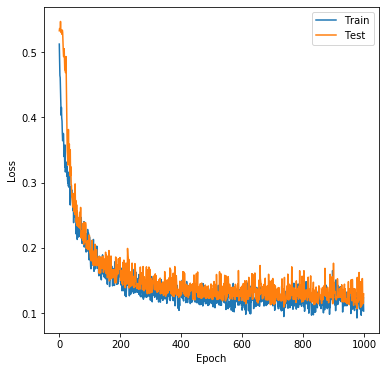

In [4]:
trained_model = atomnet.trainer(
    images_all, labels_all, 
    images_test_all, labels_test_all,
    training_cycles=1000).run()

Now let's make a prediction on the image from a different experiment ( see Applied Physics Letters 115, 052902 (2019) ):

In [5]:
# Load "validation" data
expdata = dataset['validation_img']
# Get raw NN output
input_img, pred = atomnet.predictor(
    expdata, trained_model).run()
# Transform NN output into atomic coordinates
coordinates_im = atomnet.locator(pred).run()

1 image was decoded in approximately 2.8626 seconds


Plot results:

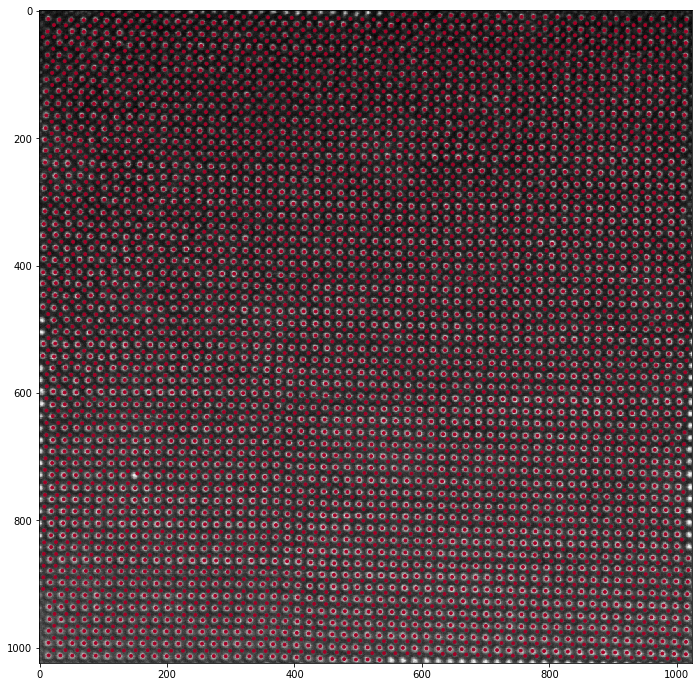

In [9]:
plot_coord(expdata, coordinates_im[0], fsize=12)

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can compare our results with the results of other methods (something that will be added in the near future).

Notice that it is always a good idea to train your model on a diverse training set (e.g. many labeled expermental images, or simulated data for variety of atomic structures/positions). Here we used a training set made from a single image just to show a *quick* example of how atomnet module works. Such a model will not generalize very well.